# Vectors & word embeddings 
A workshop by UMN LATIS and the Libraries.

## What we'll cover in this session
- Representing words as numbers
- TF-IDF
- Word vectors
- What are they? 
- How they work + Benefits
- Word Vectors with Spacy
- Interpreting results
- Word embeddings in 2d plots
- Calculating distance between pairs
- Document embedding
- Transformers


## Install required libraries
If you're working from your own machine you can use pip install to make sure you have downloaded all of the Python packages you'll need to use today. 

If you're working on notebooks.latis.umn.edu, there's no need to install any of these, since they're included in the virtual environment.

In [ ]:
# use !pip install to install libraries we'll use today
!pip install spacy

# This command downloads the medium-sized English language model for spaCy.
# It uses the Python module-running option to run spaCy's download command for the "en_core_web_md" model.
!python -m spacy download en_core_web_md 

## Changing words into numbers
- Computers require numerical representations of things like images and words to be able to store, process, and manipulate them. 
- For most text analysis methods that will allows us to work with text as data, then, it's critical to use structured formats that represent words as numbers.
- At the base level computers already use encoding standards like Unicode to represent words as numbers, but Unicode represents specific characters in numerical form, not entire words. Since we're interested in working with the meanings of words and not characters, we'll use other methods to create numerical representations of our texts.
- Rather than manually assigning words to specific numbers on our own, we can utilize existing vector frameworks to transform our texts to numerical formats that allow us to analyze meaning.

### TF-IDF: Term Frequency, Inverse Document Frequency

- TF-IDF is a statistical measure using a matrix to evaluate how important a word is to a document or corpus. 
- In a TF-IDF matrix:
 - each row represents a document
 - each column represents a unique word
 - each cell contains a score for that word in the document
 
The score increases relative to the number of times that a word appears in a document, offset by its frequency in the entire corpus. So words that are more common across the entire corpus will have lower scores in a particular document, which helps us account for common terms. 

Let's use the spacy package to transform a collection of State of the Union addresses into a TF-IDF Document Term Matrix.

#### Import required libraries

In [1]:
import spacy
import glob
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Load the spaCy model
nlp = spacy.load("en_core_web_md")

#### Tokenize the SOTU corpus with spacy

In [2]:
# Collect all speech file paths
sotu = glob.glob("sotu_text/*.txt")

# Initialize a list to store preprocessed speeches
processed_speeches = []

# Process each speech
for speech_path in sotu[0:5]:
    with open(speech_path, 'r') as file:
        text = file.read()
        doc = nlp(text)
        # Filter tokens and join them into a single string
        # ignore stop words, punctuation, spaces and digits
        tokens = [token.text.lower() for token in doc if not (token.is_stop or token.is_punct or token.is_space or token.is_digit or token.like_num)]
        processed_text = ' '.join(tokens)
        processed_speeches.append(processed_text)

### Convert to a TF-IDF Vector


In [3]:
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the first 5 preprocessed speeches to a TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(processed_speeches)

In [4]:
tfidf_matrix.get_shape()

(5, 5770)

#### Use Pandas to view the matrix

In [5]:
# Create a DataFrame for better readability
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Display the DataFrame
df_tfidf

,1791,22d,23d,2d,36,3d,abandon,abandoned,abandoning,abandonment,...,yearly,years,yield,yielded,yielding,york,yorktown,young,youth,zeal
0,0.005131,0.000000,0.004140,0.000000,0.010263,0.005131,0.000000,0.010263,0.000000,0.000000,...,0.004140,0.046457,0.016560,0.008280,0.004140,0.023127,0.000000,0.000000,0.004140,0.000000
1,0.000000,0.009912,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.029271,0.000000,0.000000,0.000000,0.027686,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.012916,0.000000,0.000000,0.000000,0.015270,0.000000,0.000000,0.000000,0.009035
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011486,0.000000,0.011486,0.011486,...,0.018534,0.027366,0.000000,0.000000,0.000000,0.000000,0.000000,0.034458,0.000000,0.000000
4,0.000000,0.007161,0.014322,0.008876,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.042295,0.007161,0.007161,0.007161,0.010001,0.008876,0.000000,0.014322,0.000000


In [6]:
# Number of top words to extract for each document
top_n = 5

# Find the top n words for each document
top_words_per_document = []
for index, row in df_tfidf.iterrows():
    top_words = row.sort_values(ascending=False).head(top_n).index.tolist()
    top_words_per_document.append(top_words)

# Print the top words for each document
for doc_index, words in enumerate(top_words_per_document):
    print(f"Document {doc_index + 1} top words: {words}")

Document 1 top words: ['states', 'government', 'public', 'country', 'congress']
Document 2 top words: ['states', 'emancipation', 'people', 'united', 'time']
Document 3 top words: ['bank', 'states', 'government', 'country', 'surplus']
Document 4 top words: ['congress', 'country', 'cable', 'conditions', 'work']
Document 5 top words: ['government', 'people', 'year', 'states', 'public']


In TF-IDF the words are assigned numbers based on their importance to each document and the corpus, but the numbers don't actually tell us anything about a word's meaning or its relationship to other words. Words vectors give us a way to understand more about how words in a corpus relate to each other.

## Word Vectors

When people refer to word vectors, or word embeddings, they're talking about a way of representing each word as a numerical vector in a high-dimensional space, typically from 50 to 300 dimensions. 

Key properties of word vectors:

1. Dimensionality: In TF-IDF there as many dimensions as there are words in the vocabulary. Word vectors typically have fewer dimensions (e.g., 100 or 300).

2. Density: Unlike TF-IDF where a vector consists mostly of 0s, word vectors are dense, meaning most elements are non-zero.

3. Learned from data: Word vectors are typically learned from large text corpora using machine learning techniques. They capture semantic and syntactic relationships between words based on their usage patterns in the text.

4. Semantic relationships: Similar words have similar vectors. For example, the vectors for "king" and "queen" might be close to each other.

5. Arithmetic operations: Word vectors often exhibit interesting arithmetic properties. A classic example is: vector("king") - vector("man") + vector("woman") ≈ vector("queen").

## How Word Vectors Work

Word vectors work on the principle of distributional semantics, which states that words that occur in similar contexts tend to have similar meanings. Machine learning models analyze large amounts of text data to learn these representations.

There are different popular models out there, such as Word2Vec, developed by Google. We'll stick with spaCy, and use the vector model that comes with "en_core_web_md".

In [15]:
token = nlp("freedom")
vector = token.vector
vector

array([-1.8414e+00,  7.3521e-01, -3.6929e+00,  4.5283e-01,  4.2076e+00,
        1.6294e+00,  4.1069e+00, -1.5520e+00, -4.2906e+00, -2.5766e+00,
        7.3838e+00,  2.4228e-01, -2.1170e+00,  1.3347e+00,  1.4605e+00,
        3.0513e+00,  3.1540e-02, -1.6935e+00, -2.4440e+00, -2.2264e+00,
       -4.7502e-01,  2.9309e-01, -4.8597e-01,  2.6505e-01, -8.6836e-01,
        2.9952e+00, -2.0902e+00,  4.6390e-01, -4.4166e+00,  4.5222e+00,
        3.2628e+00, -3.1146e+00,  3.4102e+00, -4.9460e+00,  9.1611e-01,
        2.8881e+00,  4.3991e+00, -8.8915e-01,  8.3743e-01,  5.0004e-01,
       -2.2199e+00,  1.5325e+00, -1.3836e-01,  4.7562e+00,  2.0264e-01,
        2.6771e+00,  2.4195e+00, -5.0354e-01,  6.8477e-01,  1.0058e+00,
       -2.1954e+00, -1.4514e+00, -9.1885e-01, -5.1412e+00, -6.3380e-01,
        4.0428e-01,  1.8117e+00,  2.2756e+00,  1.0712e+00,  7.7410e-01,
        1.9803e+00, -2.5526e+00,  6.9290e-02, -2.9640e+00,  1.8133e+00,
        5.8488e+00, -5.2679e+00, -4.5957e+00,  1.0157e+00, -4.46

In [20]:
def compare_words(word1, word2):
    similarity = nlp(word1).similarity(nlp(word2))
    print(f"Similarity between '{word1}' and '{word2}': {similarity:.4f}")

In [21]:
compare_words('king', 'president')
compare_words('king', 'pauper')
compare_words('president', 'pauper')

Similarity between 'king' and 'president': 0.3335
Similarity between 'king' and 'pauper': 0.2276
Similarity between 'president' and 'pauper': 0.0041


### Show word embeddings on a 2d plot

In [44]:
words = ['nurse', 'doctor', 'farmer', 'athlete', 'librarian', 'teacher']

vectors = [nlp(word).vector for word in words]

pca = PCA(n_components = 2)
vectors_2d = pca.fit_transform(vectors)


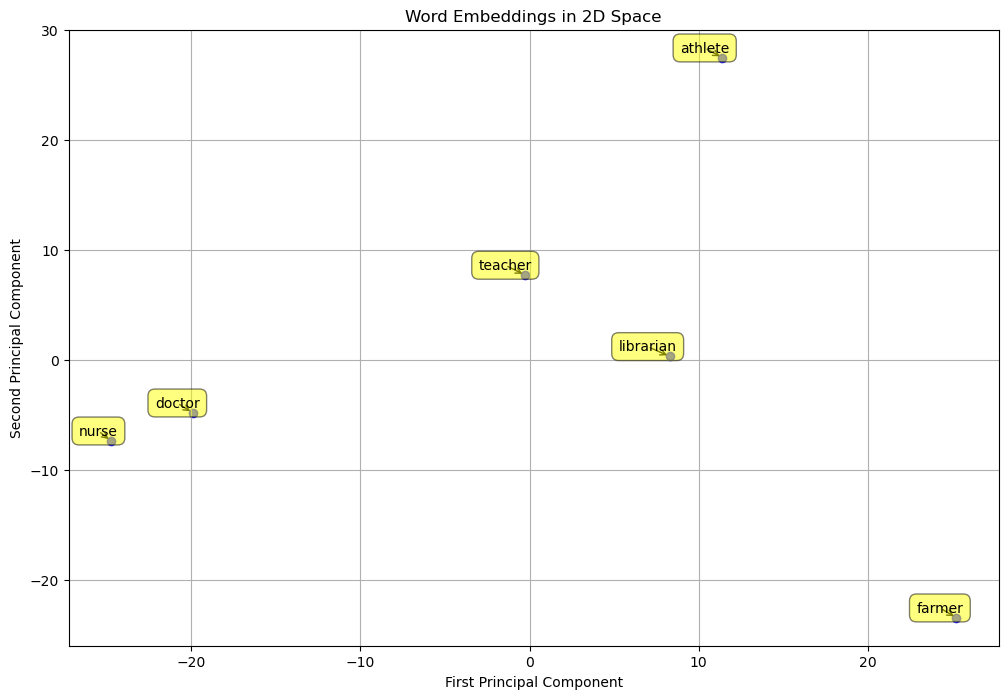

In [45]:
# Plot the words in 2D space
plt.figure(figsize=(12, 8))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c='b', alpha=0.7)

for i, word in enumerate(words):
    plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]), xytext=(5, 2), 
                 textcoords='offset points', ha='right', va='bottom',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                 arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.title("Word Embeddings in 2D Space")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.grid(True)

# Instead of plt.show(), we'll save the plot as an SVG
#plt.savefig('../outputs/word_embeddings_2d.svg', format='svg')
#print("Plot saved as 'word_embeddings_2d.svg'")

In [48]:
# Calculate and print the Euclidean distances between pairs
print("\nDistances between pairs:")
for i in range(len(words)):
    for j in range(i+1, len(words)):
        distance = np.linalg.norm(vectors_2d[i] - vectors_2d[j])
        print(f"{words[i]} - {words[j]}: {distance:.4f}")


Distances between pairs:
nurse - doctor: 5.4636
nurse - farmer: 52.4864
nurse - athlete: 50.1873
nurse - librarian: 33.9012
nurse - teacher: 28.7386
doctor - farmer: 48.8229
doctor - athlete: 44.9653
doctor - librarian: 28.6502
doctor - teacher: 23.2901
farmer - athlete: 52.7636
farmer - librarian: 29.1812
farmer - teacher: 40.2579
athlete - librarian: 27.3352
athlete - teacher: 22.9449
librarian - teacher: 11.3077
